In [ ]:
!pip install -U accelerate transformers bitsandbytes

In [ ]:
import torch
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

print("--loading models")
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto")
print("--loaded models")


The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


--randomly chosen file name1 is: filtered_86425.png
a woman and her child


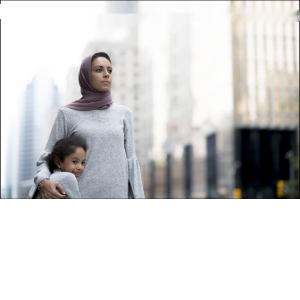


 ++++++++


In [6]:
# Sample image captioning on a random image
import os, random
IMG_DIR="/kaggle/input/facebookhatefuldataset-withouttextcaptions"

rand_file=random.choice(os.listdir(IMG_DIR)) 
print("--randomly chosen file name1 is: {}".format(rand_file))
raw_image = Image.open(IMG_DIR+"/"+rand_file).convert('RGB')

prompt = "Question: What are the objects present in this image? Answer:"
inputs = processor(images=raw_image,text=prompt,return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs,max_length=100)
print(processor.decode(out[0], skip_special_tokens=True).strip())
display(raw_image)
print("\n ++++++++")

In [8]:
def gen_caption(img):
    try:
        raw_image1 = Image.open(img).convert('RGB')
        prompt = "Question: What are the objects present in this image? Answer:"
        inputs = processor(images=raw_image1,text=prompt,return_tensors="pt").to("cuda", torch.float16)

        out = model.generate(**inputs,max_length=100)
        return (processor.decode(out[0], skip_special_tokens=True).strip()),0
    except Exception as e:
        return e,1

In [ ]:
caption_list=[]
file_list=[]
exc_list=[]
c=0

#taking a walk
for dirname, _, filenames in os.walk(IMG_DIR):
    for filename in filenames:
        f=os.path.join(dirname, filename)
        file_list.append(f)
        caption, ret_code=gen_caption(f)
        if c%10==0: print("Counter val: {0}, Image name: {1}, Caption returned: {2}".format(c,f,caption))
        caption_list.append(caption)
        exc_list.append(ret_code)
        c+=1

In [11]:
#dumping to csv
import pandas as pd
dumpdict = {'filename': file_list, 'caption_generated': caption_list, 'Pass(0)/Fail(1)': exc_list}
     
df = pd.DataFrame(dumpdict)
     
# saving the dataframe
df.to_csv('Task2_image_caption.csv')

In [12]:
#starting with pos-tagging

In [ ]:
!pip install spacy

In [14]:
import spacy
import pandas as pd
accepted_list=['NN','NNP','NNS','NNPS']
nlp = spacy.load("en_core_web_sm")

In [15]:
#sample
doc = nlp("tents, a campground, and a question mark")

for token in doc:
    if token is not token.is_stop and token.tag_ in accepted_list: #keeping only nouns and removing stopwords
        print(token.text, token.lemma_, token.pos_, token.tag_)
        


tents tent NOUN NNS
campground campground NOUN NN
question question NOUN NN
mark mark NOUN NN


In [17]:
#going through the generated captions and dumping the nouns which will act as object det classes
#sample
import pandas as pd
ip=pd.read_csv("/kaggle/working/Task2_image_caption.csv")
object_list=[]


for i in ip["caption_generated"].tolist():
    doc=nlp(str(i))
    tmp=[]
    for token in doc:
        if token is not token.is_stop and token.tag_ in accepted_list:
            tmp.append(token.lemma_)
    object_list.append(tmp)   

ip["Objects_Present"]=object_list
ip

,Unnamed: 0,filename,caption_generated,Pass(0)/Fail(1),Objects_Present
0,0,/kaggle/input/facebookhatefuldataset-withoutte...,a man in a plaid shirt sitting in the back of ...,0,"[man, shirt, back, truck]"
1,1,/kaggle/input/facebookhatefuldataset-withoutte...,The objects are the hands of the person in the...,0,"[object, hand, person, image]"
2,2,/kaggle/input/facebookhatefuldataset-withoutte...,a man with a microphone,0,"[man, microphone]"
3,3,/kaggle/input/facebookhatefuldataset-withoutte...,A donkey,0,[donkey]
4,4,/kaggle/input/facebookhatefuldataset-withoutte...,the nazi party,0,"[nazi, party]"
...,...,...,...,...,...
9995,9995,/kaggle/input/facebookhatefuldataset-withoutte...,"a man lying on the ground, covered in blood",0,"[man, ground, blood]"
9996,9996,/kaggle/input/facebookhatefuldataset-withoutte...,"a woman holding her hand to her head, a man ho...",0,"[woman, hand, head, man, hand, chest, woman, h..."
9997,9997,/kaggle/input/facebookhatefuldataset-withoutte...,A man in a pink dress,0,"[man, dress]"
9998,9998,/kaggle/input/facebookhatefuldataset-withoutte...,Donald Trump,0,"[Donald, Trump]"


In [18]:
ip.to_csv('Task2_image_caption_labels.csv')

In [20]:
#finding frequency distribution

#flattening the list of objects into one bucket for freq_dist
from itertools import chain
bucket = list((chain(*(ip["Objects_Present"].tolist()))))
len(bucket) #48k objects found across 10k images

51263

In [21]:
#doing a sanity check
print("crocodile" in bucket)#one of the images had a crocodile in it
print("cohomology" in bucket)#abstract word. no image had any object like this

True
False


In [22]:
#creating a fred_dist
freq = pd.DataFrame()
freq["set_of_labels"]=bucket
freqdict=freq["set_of_labels"].value_counts()


In [23]:
freq = freqdict.rename_axis('unique_values').reset_index(name='counts')
print (freq) #4020 rows indicating 4020 unique objects
freq.to_csv("Task2_frequency_distribution.csv")

     unique_values  counts
0              man    6319
1            woman    4333
2             suit    1326
3              dog    1217
4            child     850
...            ...     ...
2229         salon       1
2230         strip       1
2231     communist       1
2232           gay       1
2233         pride       1

[2234 rows x 2 columns]


In [ ]:
#MS COCO CLASS LIST
coco_dict={0: u'__background__',
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'}

coco_list=[*coco_dict.values()]
len(coco_list)


In [ ]:
#printing the labels collected by spacy which are not coco labels:
non_coco=[i for i in freq['unique_values'].tolist() if i not in coco_list]
len(non_coco)

In [ ]:
non_coco #these are the objects that would not have been caught by object-det models pretrained on MS COCO